In [1]:
import numpy as np
import dynalearn as dl
import matplotlib.pyplot as plt
import tensorflow as tf
import os

In [2]:
dynamics_config = {
        "name": "PlanckSIS",
        "params": {"temperature": 8, "recovery": 0.06, "init": "None"},
    }
graph_config = {"name": "BAGraph", "params": {"N": 1000, "M": 2}}
model_config = dl.models.GNNConfig.SISGNN()
metric_config = dl.metrics.MetricsConfig.PlanckSISMetrics()
metric_config.epsilon = 1e-2

num_sample = 20000
num_epochs = 20

name = "plancksis-ba-{0}".format(num_sample)

path_to_model = "../data/test"
path_to_data = os.path.join("../data/test", name)
training_config = dl.TrainingConfig.changing_num_samples(num_sample)
training_config.step_per_epoch = num_sample
training_config.num_epochs = num_epochs

config = {
    "name": name,
    "graph": graph_config,
    "dynamics": dynamics_config,
    "model": {"name": "EpidemicPredictor", "config": model_config},

    "generator": {
        "name": "DynamicsGenerator",
        "config": dl.datasets.GeneratorConfig.default(),
        "sampler": {
            "name": "StateBiasedSampler",
            "config": dl.datasets.samplers.SamplerConfig.BiasedSamplerDefault(
                dynamics_config, 0.6
            ),
        },
    },
    "metrics": {
        "name": [
            "AttentionMetrics",
            "TrueLTPMetrics",
            "GNNLTPMetrics",
            "MLELTPMetrics",
            "TrueStarLTPMetrics",
            "GNNStarLTPMetrics",
            "UniformStarLTPMetrics",
            "StatisticsMetrics",
            "TruePEMFMetrics",
            "GNNPEMFMetrics",
        ],
        "config": metric_config,
    },
    "training": training_config,
    "path_to_data": path_to_data,
    "path_to_model": path_to_model,
}

In [3]:
tf_config = tf.ConfigProto()
tf_config.gpu_options.allow_growth = True
session = tf.Session(config=tf_config)
experiment = dl.Experiment(config, verbose=1)


In [4]:
experiment.generate_data()

Generating data - 0.0082s: 100%|██████████| 20000/20000 [02:40<00:00, 124.88it/s] 


Partitioning generator for validation


In [5]:
experiment.train_model()


Epoch 00001: LearningRateScheduler reducing learning rate to 0.0005000000237487257.
Epoch 1/20
19996/20000 [============================>.] - ETA: 0s - loss: 0.2368 - model_entropy: 0.2000
Epoch 00001: val_loss improved from inf to 0.30784, saving model to ../data/test/plancksis-ba-20000.h5
20000/20000 [==============================] - 370s 18ms/step - loss: 0.2368 - model_entropy: 0.2000 - val_loss: 0.3078 - val_model_entropy: 0.1697

Epoch 00002: LearningRateScheduler reducing learning rate to 0.0005000000237487257.
Epoch 2/20
19997/20000 [============================>.] - ETA: 0s - loss: 0.2208 - model_entropy: 0.1637
Epoch 00002: val_loss improved from 0.30784 to 0.30171, saving model to ../data/test/plancksis-ba-20000.h5
20000/20000 [==============================] - 390s 19ms/step - loss: 0.2208 - model_entropy: 0.1637 - val_loss: 0.3017 - val_model_entropy: 0.1678

Epoch 00003: LearningRateScheduler reducing learning rate to 0.0005000000237487257.
Epoch 3/20
19998/20000 [=====

In [6]:
experiment.load_model(best=True)
experiment.metrics["TrueStarLTPMetrics"].compute(experiment)
experiment.metrics["GNNStarLTPMetrics"].compute(experiment)

 33%|███▎      | 440/1340 [00:00<00:00, 4397.99it/s]

Computing TrueStarLTPMetrics


  2%|▏         | 31/1340 [00:00<00:04, 307.75it/s]

Computing GNNStarLTPMetrics


100%|██████████| 1340/1340 [00:01<00:00, 931.74it/s]


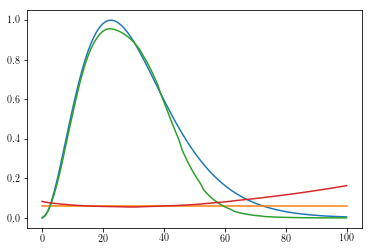

In [7]:
data = experiment.metrics["TrueStarLTPMetrics"].aggregate(in_state=0, out_state=1)
plt.plot(data[0], data[1])
data = experiment.metrics["TrueStarLTPMetrics"].aggregate(in_state=1, out_state=0)
plt.plot(data[0], data[1])

data = experiment.metrics["GNNStarLTPMetrics"].aggregate(in_state=0, out_state=1)
plt.plot(data[0], data[1])
data = experiment.metrics["GNNStarLTPMetrics"].aggregate(in_state=1, out_state=0)
plt.plot(data[0], data[1])

In [8]:

experiment.metrics["TruePEMFMetrics"].epsilon = 1e-2
experiment.metrics["TruePEMFMetrics"].compute(experiment)
experiment.metrics["GNNPEMFMetrics"].epsilon = 1e-2
experiment.metrics["GNNPEMFMetrics"].compute(experiment)

Thresholds:   0%|          | 0/34 [00:00<?, ?it/s]

Computing TruePEMFMetrics


Thresholds:   0%|          | 0/34 [00:00<?, ?it/s]

Computing GNNPEMFMetrics


Fixed points: 100%|██████████| 140/140 [01:11<00:00,  2.17it/s]


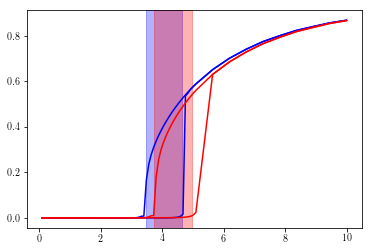

In [11]:
x = experiment.metrics["TruePEMFMetrics"].data["parameters"]
y = experiment.metrics["TruePEMFMetrics"].data["fixed_points"]
t = experiment.metrics["TruePEMFMetrics"].data["thresholds"]
plt.plot(x, 1 - y[0,:,0], 'b')
plt.plot(x, 1 - y[1,:,0], 'b')
plt.axvspan(t[0], t[1], color="b", alpha=0.3)

x = experiment.metrics["GNNPEMFMetrics"].data["parameters"]
y = experiment.metrics["GNNPEMFMetrics"].data["fixed_points"]
t = experiment.metrics["GNNPEMFMetrics"].data["thresholds"]
plt.plot(x, 1 - y[0,:,0], 'r')
plt.plot(x, 1 - y[1,:,0], 'r')
plt.axvspan(t[0], t[1], color="r", alpha=0.3)

# plt.axvline(t[0], color="b", alpha=0.3, linestyle='-')

# x = experiment.metrics["PoissonEpidemicsMFMetrics"].parameters
# y1 = experiment.metrics["PoissonEpidemicsMFMetrics"].data["gnn_low_fp"]
# y2 = experiment.metrics["PoissonEpidemicsMFMetrics"].data["gnn_high_fp"]
# t = experiment.metrics["PoissonEpidemicsMFMetrics"].data["gnn_thresholds"]
# plt.plot(x, 1 - y1[:,0], ls='--', c='r')
# plt.plot(x, 1 - y2[:,0], ls='--', c='r')
# plt.axvspan(t[0], t[1], color="r", alpha=0.3)
# plt.xlim([2, 6])